In [1]:
import sys
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqUtils import GC
from Bio.SeqUtils import MeltingTemp as mt
import seaborn as sns
import matplotlib.pyplot as plt
import primer3
import statistics
import time
import gffpandas.gffpandas as gffpd
from functions import *
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio.Seq import Seq
from tqdm import tqdm

This notebook makes primers with an input sequence to be assemble. 

In [2]:
# ########################################################################################################################### #
#                                                                                                                             #
# THIS CELL IS USEFULL ONLY AND ONLY IF U USE gff3 file provided with generate_recoded_and_refactored_genome                  #
#                                                                                                                             #
# ########################################################################################################################### #

def merge_intervals(intervals):
    #get list of tuple as input
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return merged

def get_restricted_region_from_ourgff3(path_to_wt_fasta,path_to_annotation_df,path_to_recnref_fasta,start_sequence,end_sequence,term_filename):
    #the wtz and recnref version must have same pcr primers. Exclude the different region of the two versions to create a list of forbidden places for primers.
    wt_fasta = SeqIO.read(path_to_wt_fasta, "fasta").seq
    annotation_df = (gffpd.read_gff3(path_to_annotation_df)).df
    # set annotation to 0 based
    annotation_df['start'] -= 1
    recnref_genome = SeqIO.read(path_to_recnref_fasta, "fasta").seq
    
    #Find the beginning of the fasta recnref file:
    start = recnref_genome.find(start_sequence)
    end = recnref_genome.find(end_sequence)+len(end_sequence)
    
    print('start',start,'end',end)
    
    #wt_start: usefull when the terminator files are based on the wt_fasta file of L1.
    #define the beginning of the fasta file provided
    wt_start = wt_fasta.find(start_sequence)
    #last primer: find the end
    wt_end = wt_fasta.find(end_sequence)+len(end_sequence)

    annotation_df = annotation_df.loc[(annotation_df["start"] >= start) & (end >= annotation_df["end"])]

    annotation_df.drop(["seq_id","source","type",'score',"phase",], axis=1, inplace=True)
    annotation_df['start'] -= start
    annotation_df["end"] -= start
    annotation_df = annotation_df.rename(columns={"attributes": 'name'})
    annotation_df = annotation_df[['name', 'start', 'end', 'strand']]
    
    #REMOVE THE FIRST COLUMN:
    annotation_df = annotation_df.iloc[1:].reset_index(drop=True)

    #create a list of excluded coordinates: restricted region (including reedited parts) with only the recnref file
    restricted_region = []
    for idx, attributes in enumerate(annotation_df["name"]):
        if "rec" not in attributes:
            restricted_region.append((annotation_df['start'][idx],annotation_df['end'][idx]))
        else:
            continue

    #print('je suis restricted_region',restricted_region)
    # Merge initial restricted regions:
    # There is always maximum 2 overlapping regions in restricted_region:
      
                
    #####We have to add the terminator region as restricted regions:
    # those are 0-based, no coords modification needed
    terminator_df = pd.read_csv(term_filename, sep="\t")
    for i in range(len(terminator_df)):
        if terminator_df["term start"][i] > wt_start and terminator_df["term stop"][i] < wt_end:
            term_start = int(terminator_df["term start"][i])
            term_end = int(terminator_df["term stop"][i])
    # I had the proof these coordinates work:
            terminator_seq = str(wt_fasta[term_start:term_end])
            restricted_region.append((ref_40kbfasta.find(terminator_seq),ref_40kbfasta.find(terminator_seq)+len(terminator_seq)))

    # Position to add other annotations, be careful, we are using 0 based annotation!
    # So we must correct positions when importing gff annotations
            
    restricted_region = merge_intervals(restricted_region)
    restricted_region = [str(i[0])+':'+str(i[1]) for i in restricted_region]

    return restricted_region


def get_annotation_df_from_gff3(path_to_wt_fasta,path_to_annotation_df,path_to_recnref_fasta):
    wt_fasta = SeqIO.read(path_to_wt_fasta, "fasta").seq
    annotation_df = (gffpd.read_gff3(path_to_annotation_df)).df
    # set annotation to 0 based
    annotation_df['start'] -= 1
    recnref_genome = SeqIO.read(path_to_recnref_fasta, "fasta").seq


    #Find the beginning of the fasta recnref file:
    start = recnref_genome.find('TAGTAGAGGTAAAATATG')
    end = recnref_genome.find('TAGAACTAAACACTAG')+len('TAGAACTAAACACTAG')

    annotation_df = annotation_df.loc[(annotation_df["start"] >= start) & (end >= annotation_df["end"])]
    annotation_df.drop(["seq_id","source","type",'score',"phase",], axis=1, inplace=True)
    annotation_df['start'] -= start
    annotation_df["end"] -= start
    annotation_df = annotation_df.rename(columns={"attributes": 'name'})
    annotation_df = annotation_df[['name', 'start', 'end', 'strand']]
    print(annotation_df)
    #REINDEX THE FIRST COLUMN:
    annotation_df = annotation_df.iloc[0:].reset_index(drop=True)
    return annotation_df

def get_number_of_primers(len_min,len_max,len_fragment):
    i = len_min
    number_of_primers = 0
    while i <= len_max:
        number_of_primers = number_of_primers + (len_fragment-(i-1))
        i+=1
    return number_of_primers

def primer_dict_to_df(dict):
    pair_list = []
    number_of_pairs = dict['PRIMER_PAIR_NUM_RETURNED']
    try:
        for i in range(number_of_pairs):
            pair_list = pair_list + [{
                'PRIMER_LEFT_SEQUENCE' : dict['PRIMER_LEFT_'+str(i)+'_SEQUENCE'],
                'PRIMER_RIGHT_SEQUENCE' : dict['PRIMER_RIGHT_'+str(i)+'_SEQUENCE'],
                'PRIMER_LEFT_POSITION' : dict['PRIMER_LEFT_'+str(i)][0],
                'PRIMER_RIGHT_POSITION' : dict['PRIMER_RIGHT_'+str(i)][0],
                'PRIMER_LEFT_TM': dict['PRIMER_LEFT_'+str(i)+'_TM'],
                'PRIMER_RIGHT_TM': dict['PRIMER_RIGHT_'+str(i)+'_TM'],
                'PRIMER_PENALTY' : statistics.mean([dict['PRIMER_LEFT_'+str(i)+'_PENALTY'],dict['PRIMER_RIGHT_'+str(i)+'_PENALTY']])
            }]
    except:
        print(dict)
        print("censored")
    return pd.DataFrame(pair_list)

#Define parameters to give to this functions:
def make_sequencing_primers_rec(seq, fragment_number,coordinates_sequence_template, prev, min_overlap_len, max_overlap_len, 
                                window_len,restricted_region_ordered, index, is_starting = False, verbose = False, recoil_number = [], liste_primers_d = []):
    """
    This is a recursive function giving the best primers found with Primer3.
    """
    if verbose:print(fragment_number)
    if fragment_number == 0:
        
        #safety purposes
        if is_starting:
            if len(recoil_number) > 0:
                if verbose:print("le fragment_number n'est pas bien initialise, mais nous avons corrige le tir")
                recoil_number = []
            if len(liste_primers_d) > 0:
                if verbose:print("la liste_primers_d n'est pas bien initialisee, mais nous avons corrige le tir")
                liste_primers_d = []
            is_starting = False

        #Find right coordinates
        coordinates_sequence_template = find_right_coordinates(index,restricted_region_ordered,max_overlap_len,window_len,prev[fragment_number],0,verbose)

        if verbose:print('je suis coordinates_sequence_template : '+str(coordinates_sequence_template))
        if verbose:print('current_coordinates_sequence_template : '+str(coordinates_sequence_template))
        if verbose:print('type de current_coordinates_sequence_template : '+str(type(coordinates_sequence_template[0])))

        #Primer3 design primer with these parameters:
        primers = (primer3.bindings.designPrimers(
            {
                'SEQUENCE_ID': 'debut',
                'SEQUENCE_TEMPLATE': str(seq[:coordinates_sequence_template[1]]),
                'SEQUENCE_EXCLUDED_REGION': [0,coordinates_sequence_template[1]-max_overlap_len],
                'SEQUENCE_PRIMER': first_left_primer_sequence
            },
            {
                'PRIMER_TASK': 'generic',
                'PRIMER_PICK_LEFT_PRIMER': 0,
                'PRIMER_PICK_INTERNAL_OLIGO': 0,
                'PRIMER_PICK_RIGHT_PRIMER': 1,
                'PRIMER_NUM_RETURN': get_number_of_primers(18,36,max_overlap_len),
                'PRIMER_OPT_SIZE': 20,
                'PRIMER_MIN_SIZE': 18,
                'PRIMER_MAX_SIZE': 36,
                'PRIMER_OPT_TM': 57.0,
                'PRIMER_MIN_TM': 49.5,
                'PRIMER_MAX_TM': 64.0,
                'PRIMER_MAX_POLY_X' : 8,
                'PRIMER_MAX_HAIRPIN_TH' : 10.0,
                'PRIMER_MAX_GC' : 90.0,
                'PRIMER_MIN_GC' : 1.0,
                'PRIMER_PRODUCT_SIZE_RANGE': [coordinates_sequence_template[1]-max_overlap_len,coordinates_sequence_template[1]]
            }
        ))
        pair_list = []
        number_of_pairs = int((len(primers)-5)/9)
        for i in range(number_of_pairs):
            pair_list = pair_list + [{
                'PRIMER_LEFT_SEQUENCE' : first_left_primer_sequence,
                'PRIMER_RIGHT_SEQUENCE' : primers['PRIMER_RIGHT_'+str(i)+'_SEQUENCE'],
                'PRIMER_LEFT_POSITION' : 0,
                'PRIMER_RIGHT_POSITION' : primers['PRIMER_RIGHT_'+str(i)][0],
                'PRIMER_LEFT_TM': '56',
                'PRIMER_RIGHT_TM': primers['PRIMER_RIGHT_'+str(i)+'_TM'],
                'PRIMER_PENALTY' : primers['PRIMER_RIGHT_'+str(i)+'_PENALTY']
            }]
        primers_df = pd.DataFrame(pair_list)
        primers_df['PRIMER_RIGHT_POSITION'] = primers_df['PRIMER_RIGHT_POSITION'] + 1
        
        #In the case of a small region to find primers, we keep at least 80 pb of overlap for the left primer of the next gblock:
        primers_df = primers_df.loc[primers_df['PRIMER_RIGHT_POSITION'] > coordinates_sequence_template[0]+min_overlap_len ]
        primers_df.sort_values(by='PRIMER_PENALTY', inplace = True)
        primers_df.reset_index(inplace=True)
        
        #Remove primers with GGGG
        for idx,pair in primers_df.iterrows():
            if 'GGGG' in pair['PRIMER_LEFT_SEQUENCE'] or 'GGGG' in pair['PRIMER_RIGHT_SEQUENCE']:
                primers_df.drop(idx, inplace=True)

        primers_df.sort_values(by='PRIMER_PENALTY', inplace = True)
        primers_df.reset_index(inplace=True)
        
        #If no primer could be found in right region:
        have_no_right_primers = len(primers_df) == 0
    
        if have_no_right_primers:
            index += 1
            #peut etre une limite de longueur minimale?
            return make_sequencing_primers_rec(seq = seq, fragment_number = fragment_number,coordinates_sequence_template = coordinates_sequence_template, prev = prev,
                                                         min_overlap_len = min_overlap_len ,max_overlap_len = max_overlap_len,window_len = window_len,
                                                         restricted_region_ordered = restricted_region_ordered, index=index, verbose = verbose, recoil_number = recoil_number,
                                                         liste_primers_d = liste_primers_d)
        else:
            #Change prev for the next iteration:
            prev.append(primers_df.loc[0,'PRIMER_RIGHT_POSITION'])
            
            #initialize recoil_number[fragment_number] if no primers are found:   
            if fragment_number > len(recoil_number) -1:
                recoil_number.append(0)

            #Dictionnary to fill :
            primers_d = {
                'PRIMER_LEFT_SEQUENCE': first_left_primer_sequence,
                'PRIMER_LEFT_POSITION': 0,
                'PRIMER_LEFT_TM': '56',
                'PRIMER_RIGHT_SEQUENCE': primers_df.loc[0,'PRIMER_RIGHT_SEQUENCE'],
                'PRIMER_RIGHT_POSITION': primers_df.loc[0,'PRIMER_RIGHT_POSITION'],
                'PRIMER_RIGHT_TM': primers_df.loc[0,'PRIMER_RIGHT_TM'],
                'PRIMER_PENALTY' : primers_df.loc[0,'PRIMER_PENALTY']
            }
            if verbose:print(primers_d)
            if verbose:print(type(restricted_region_ordered))
            
            
            if fragment_number > len(liste_primers_d) -1:
                liste_primers_d.append(primers_d)
            else:
                liste_primers_d[fragment_number] = primers_d
                
            index = 1
            fragment_number += 1
            
            return make_sequencing_primers_rec(seq = seq, fragment_number = fragment_number, coordinates_sequence_template = coordinates_sequence_template, 
                                                             prev = prev,min_overlap_len = min_overlap_len ,max_overlap_len = max_overlap_len,window_len = window_len, 
                                                             restricted_region_ordered = restricted_region_ordered, index=1, verbose = verbose, recoil_number = recoil_number,
                                                             liste_primers_d = liste_primers_d)
             
               
    # The end
    elif (prev[fragment_number] - max_overlap_len + window_len) >= len(seq):
        
        #if primers_df exist already (notebook iterations might not work in this case):
        if verbose:print("###")
        if verbose:print("###")
        if verbose:print("Last gblock")
        if verbose:print(type(liste_primers_d))
        if verbose:print(liste_primers_d)
        if verbose:print("en ordre le type et la liste desiree")
           
        last_higher_restricted_border = [int(i.split(":")[1]) for i in restricted_region_ordered if prev[fragment_number] > int(i.split(":")[1])]

        #to make sure no int_64 appears in this list:
        prev = [int(i) for i in prev]
        #if no restricted area in the last case:
        if len(last_higher_restricted_border) == 0:
            right_coordinates = [int(prev[fragment_number] - max_overlap_len), int(prev[fragment_number])]

       #Depending on the length of the inbetween of 2 restricted regions, 2 cases possible: larger or smaller than max_overlap_len
        else:
            if  max(last_higher_restricted_border) < int(prev[fragment_number])-max_overlap_len:
                right_coordinates = [int(prev[fragment_number] - max_overlap_len), int(prev[fragment_number])]
            elif max(last_higher_restricted_border) <= int(prev[fragment_number])-min_overlap_len :
                right_coordinates = [int(max(last_higher_restricted_border)),int(prev[fragment_number])]

            #Should never respect these conditions: at least 200 bp in the inbetween regions
            else:
                print(' "a laide" **the sad story of a programmer** ')
        
        if verbose:print('len of last gblock:',len(str(Seq(seq[right_coordinates[0]:]).reverse_complement())))
        if verbose:print('je suis prev[fragment_number] :'+str(prev[fragment_number]))
        if verbose:print('right_coordinates : '+str(right_coordinates))
        if verbose:print('SEQUENCE_EXCLUDED_REGION : ',[0,len(seq)-prev[fragment_number]])
        if verbose:print('PRIMER_PRODUCT_SIZE_RANGE : ',[len(seq)-prev[fragment_number]+min_overlap_len,len(seq)-int(right_coordinates[0])])
        print(str(Seq(seq[right_coordinates[0]:]).reverse_complement()))
        
        primers = (primer3.bindings.designPrimers(
            {
                'SEQUENCE_ID': 'bidon',
                'SEQUENCE_TEMPLATE': str(Seq(seq[right_coordinates[0]:]).reverse_complement()),
                'SEQUENCE_EXCLUDED_REGION': [0,len(seq)-prev[fragment_number]],
                'SEQUENCE_PRIMER': last_right_primer_sequence_rc
            },
            {
                'PRIMER_TASK': 'generic',
                'PRIMER_PICK_LEFT_PRIMER': 0,
                'PRIMER_PICK_INTERNAL_OLIGO': 0,
                'PRIMER_PICK_RIGHT_PRIMER': 1,
                'PRIMER_NUM_RETURN': get_number_of_primers(18,36,max_overlap_len),
                'PRIMER_OPT_SIZE': 20,
                'PRIMER_MIN_SIZE': 18,
                'PRIMER_MAX_SIZE': 36,
                'PRIMER_OPT_TM': 57.0,
                'PRIMER_MIN_TM': 49.5,
                'PRIMER_MAX_TM': 64.0,
                'PRIMER_MAX_POLY_X' : 8,
                'PRIMER_MAX_HAIRPIN_TH' : 10.0,
                'PRIMER_MAX_GC' : 90.0,
                'PRIMER_MIN_GC' : 1.0,
                'PRIMER_PRODUCT_SIZE_RANGE': [len(seq)-prev[fragment_number]+min_overlap_len,len(seq)-int(right_coordinates[0])]
            }
        ))
        pair_list = []
        number_of_pairs = int((len(primers)-5)/9)
        for i in range(number_of_pairs):
            pair_list = pair_list + [{
                'PRIMER_LEFT_SEQUENCE' : str(Seq(primers['PRIMER_RIGHT_'+str(i)+'_SEQUENCE'])),
                'PRIMER_RIGHT_SEQUENCE' : last_right_primer_sequence_rc,
                'PRIMER_LEFT_POSITION' : ((len(seq[right_coordinates[0]:]))-(int(primers['PRIMER_RIGHT_'+str(i)][0])+1)),
                'PRIMER_RIGHT_POSITION' : len(seq),
                'PRIMER_LEFT_TM': primers['PRIMER_RIGHT_'+str(i)+'_TM'],
                'PRIMER_RIGHT_TM': '57',
                'PRIMER_PENALTY' : primers['PRIMER_RIGHT_'+str(i)+'_PENALTY']
            }]

        primers_df = pd.DataFrame(pair_list)
        primers_df['PRIMER_LEFT_POSITION'] = primers_df['PRIMER_LEFT_POSITION'] + right_coordinates[0]
        primers_df = primers_df.loc[primers_df['PRIMER_LEFT_POSITION'] < prev[fragment_number] - min_overlap_len]
        primers_df.sort_values(by='PRIMER_PENALTY', inplace = True)
        primers_df.reset_index(inplace=True)
        
        # Remove primers with GGGG
        for idx,pair in primers_df.iterrows():
            if 'GGGG' in pair['PRIMER_LEFT_SEQUENCE'] or 'GGGG' in pair['PRIMER_RIGHT_SEQUENCE']:
                primers_df.drop(idx, inplace=True)

        primers_df.sort_values(by='PRIMER_PENALTY', inplace = True)
        primers_df.reset_index(inplace=True)
        
        have_no_left_primers = len(primers_df) == 0
        
        if have_no_left_primers:
            fragment_number -= 1
            prev = prev[:-1]
            index = 2+recoil_number[fragment_number]
            recoil_number[fragment_number] += 1
            return make_sequencing_primers_rec(seq = seq, fragment_number = fragment_number,coordinates_sequence_template = coordinates_sequence_template, prev = prev,
                                                    min_overlap_len = min_overlap_len ,max_overlap_len = max_overlap_len,window_len = window_len,
                                                    restricted_region_ordered = restricted_region_ordered, index=index, verbose = verbose, recoil_number = recoil_number,
                                                    liste_primers_d = liste_primers_d)
        
        else:                    
            primers_d = {
                'PRIMER_LEFT_SEQUENCE': primers_df.loc[0,'PRIMER_LEFT_SEQUENCE'],
                'PRIMER_LEFT_POSITION': primers_df.loc[0,'PRIMER_LEFT_POSITION'],
                'PRIMER_LEFT_TM': primers_df.loc[0,'PRIMER_LEFT_TM'],
                'PRIMER_RIGHT_SEQUENCE': last_right_primer_sequence_rc,
                'PRIMER_RIGHT_POSITION': len(seq),
                'PRIMER_RIGHT_TM': '57',
                'PRIMER_PENALTY' : primers_df.loc[0,'PRIMER_PENALTY']
            }
            if verbose:print(primers_d)
            if fragment_number > len(liste_primers_d) -1:
                liste_primers_d.append(primers_d)
            else:
                liste_primers_d[fragment_number] = primers_d

            return liste_primers_d
        
    
    
#For the general case:
    else:
        #if no restricted region:
        last_higher_restricted_border = [int(i.split(":")[1]) for i in restricted_region_ordered if prev[fragment_number] > int(i.split(":")[1])]
        if last_higher_restricted_border:
            if verbose:print("max of last higher restriced border: ", max(last_higher_restricted_border))
        
        #if no restricted area in the last case:
        if len(last_higher_restricted_border) == 0:
            left_coordinates = [int(prev[fragment_number] - max_overlap_len), int(prev[fragment_number])]

       #Depending on the length of the inbetween of 2 restricted regions, 2 cases possible: larger or smaller than max_overlap_len
        else:
            if max(last_higher_restricted_border) < int(prev[fragment_number])-max_overlap_len:
                left_coordinates = [int(prev[fragment_number] - max_overlap_len), int(prev[fragment_number])]
            elif max(last_higher_restricted_border) <= int(prev[fragment_number])-min_overlap_len :
                left_coordinates = [int(max(last_higher_restricted_border)),int(prev[fragment_number])]

            #Should never respect these conditions: at least min_overlap bp in the inbetween of restricted regions
            else:
                print(' **1the sad story of a programmer** ')

        #Find the right place:
        coordinates_sequence_template = find_right_coordinates(index,restricted_region_ordered,max_overlap_len,window_len,prev[fragment_number],left_coordinates[0],verbose)
        current_coordinates_sequence_template = [int(element) for element in coordinates_sequence_template]
        if verbose:print(current_coordinates_sequence_template)

        prev[fragment_number]=int(prev[fragment_number])
        if verbose:print('je suis prev[fragment_number] :'+str(prev[fragment_number]))
        if verbose:print('je suis current_sequence_template : '+str(current_coordinates_sequence_template))

        if verbose:print('left_coordinates : '+str(left_coordinates))
        if verbose:print('current_coordinates_sequence_template : '+str(current_coordinates_sequence_template))
#         print('SEQUENCE_TEMPLATE : '+ str(seq[left_coordinates[0]:current_coordinates_sequence_template[1]]))
        if verbose:print('SEQUENCE_EXCLUDED_REGION : '+str(prev[fragment_number]-left_coordinates[0])+', '+str(current_coordinates_sequence_template[0]-prev[fragment_number]))
        if verbose:print('PRIMER_PRODUCT_SIZE_RANGE : '+ str(current_coordinates_sequence_template[0]-left_coordinates[1])+', '+str(current_coordinates_sequence_template[1] - left_coordinates[0]))

        primers = (primer3.bindings.designPrimers(
            {
                'SEQUENCE_ID': 'bidon',
                'SEQUENCE_TEMPLATE': str(seq[left_coordinates[0]:current_coordinates_sequence_template[1]]),
                'SEQUENCE_EXCLUDED_REGION':[prev[fragment_number]-left_coordinates[0], 
                                            current_coordinates_sequence_template[0]-prev[fragment_number]]
            },
            {
                'PRIMER_TASK': 'generic',
                'PRIMER_PICK_LEFT_PRIMER': 1,
                'PRIMER_PICK_INTERNAL_OLIGO': 0,
                'PRIMER_PICK_RIGHT_PRIMER': 1,
                'PRIMER_NUM_RETURN': get_number_of_primers(18,36,max_overlap_len)*2,
                'PRIMER_OPT_SIZE': 20,
                'PRIMER_MIN_SIZE': 18,
                'PRIMER_MAX_SIZE': 36,
                'PRIMER_OPT_TM': 57.0,
                'PRIMER_MIN_TM': 49.5,
                'PRIMER_MAX_TM': 64.0,
                'PRIMER_MAX_POLY_X' : 8,
                'PRIMER_MAX_HAIRPIN_TH' : 10.0,
                'PRIMER_MAX_GC' : 90.0,
                'PRIMER_MIN_GC' : 1.0,
                'PRIMER_PRODUCT_SIZE_RANGE': [current_coordinates_sequence_template[0]-prev[fragment_number]-min_overlap_len , 
                                              current_coordinates_sequence_template[1]-left_coordinates[0]]
            }
        ))

        primers_df = primer_dict_to_df(primers)            
        primers_df['PRIMER_LEFT_POSITION'] = primers_df['PRIMER_LEFT_POSITION'] + left_coordinates[0]
        primers_df['PRIMER_RIGHT_POSITION'] = primers_df['PRIMER_RIGHT_POSITION'] + left_coordinates[0] + 1

        #remove primers with GGGG:
        for idx,pair in primers_df.iterrows():
            if 'GGGG' in pair['PRIMER_LEFT_SEQUENCE'] or 'GGGG' in pair['PRIMER_RIGHT_SEQUENCE']:
                primers_df.drop(idx, inplace=True)      
        primers_df.sort_values(by='PRIMER_PENALTY', inplace = True)
        primers_df.reset_index(inplace=True)
        
        #Make the verification df:
        have_no_right_primers = len(primers_df.loc[primers_df['PRIMER_RIGHT_POSITION'] > current_coordinates_sequence_template[0]+min_overlap_len]) == 0
        have_no_left_primers = len(primers_df.loc[primers_df['PRIMER_LEFT_POSITION'] < prev[fragment_number] - min_overlap_len]) == 0
        primers_df = primers_df.loc[(primers_df['PRIMER_RIGHT_POSITION'] > current_coordinates_sequence_template[0]+min_overlap_len) & 
            (primers_df['PRIMER_LEFT_POSITION'] < prev[fragment_number] - min_overlap_len)]

        primers_df.sort_values(by='PRIMER_PENALTY', inplace = True)
        primers_df.reset_index(inplace=True)
        
        have_no_pairs = len(primers_df) == 0
        
        if verbose:print('len of primers_df:',len(primers_df))
        
        if have_no_right_primers:
            index += 1
            #peut etre une limite de longueur minimale?
            return make_sequencing_primers_rec(seq = seq, fragment_number = fragment_number,coordinates_sequence_template = coordinates_sequence_template, prev = prev,
                                                         min_overlap_len = min_overlap_len ,max_overlap_len = max_overlap_len,window_len = window_len,
                                                         restricted_region_ordered = restricted_region_ordered, index=index, verbose = verbose, recoil_number = recoil_number,
                                                          liste_primers_d = liste_primers_d)
        elif have_no_left_primers or have_no_pairs:
            if verbose:print("je suis fragment number")
            if verbose:print(fragment_number)
            if verbose:print("je suis recoil_number :) ")
            if verbose:print(recoil_number)
            fragment_number -= 1
            prev = prev[:-1]
            index = 2+recoil_number[fragment_number]
            #print("je suis index apres recoil_number : "+str(index))
            recoil_number[fragment_number] += 1
            return make_sequencing_primers_rec(seq = seq, fragment_number = fragment_number,coordinates_sequence_template = coordinates_sequence_template, prev = prev,
                                                    min_overlap_len = min_overlap_len ,max_overlap_len = max_overlap_len,window_len = window_len,
                                                    restricted_region_ordered = restricted_region_ordered, index=index, verbose = verbose, recoil_number = recoil_number, 
                                                    liste_primers_d = liste_primers_d)

        else :
            if verbose:print('primer_df apres filtres')
            if verbose:print(primers_df)
            

            #Add the primer right position as prev[fragment_number] in prev:
            prev.append(primers_df.loc[0,'PRIMER_RIGHT_POSITION'])
            
            #initialize recoil_number[fragment_number] if no primers are found:   
            if fragment_number > len(recoil_number) -1:
                recoil_number.append(0)

            primers_d = {
                'PRIMER_LEFT_SEQUENCE': primers_df.loc[0,'PRIMER_LEFT_SEQUENCE'],
                'PRIMER_LEFT_POSITION': primers_df.loc[0,'PRIMER_LEFT_POSITION'],
                'PRIMER_LEFT_TM': primers_df.loc[0,'PRIMER_LEFT_TM'],
                'PRIMER_RIGHT_SEQUENCE': primers_df.loc[0,'PRIMER_RIGHT_SEQUENCE'],
                'PRIMER_RIGHT_POSITION': primers_df.loc[0,'PRIMER_RIGHT_POSITION'],
                'PRIMER_RIGHT_TM': primers_df.loc[0,'PRIMER_RIGHT_TM'],
                'PRIMER_PENALTY' : primers_df.loc[0,'PRIMER_PENALTY']
            }
            
            if fragment_number > len(liste_primers_d) -1:
                liste_primers_d.append(primers_d)
            else:
                liste_primers_d[fragment_number] = primers_d
                
            index = 1
            fragment_number += 1
#             print(prev)
#             print(fragment_number)
#             print(coordinates_sequence_template)
            return make_sequencing_primers_rec(seq = seq, fragment_number = fragment_number,coordinates_sequence_template = coordinates_sequence_template, prev = prev,
                                                             min_overlap_len = min_overlap_len ,max_overlap_len = max_overlap_len,window_len = window_len,
                                                             restricted_region_ordered = restricted_region_ordered, index=index, verbose = verbose, recoil_number =  recoil_number,
                                                            liste_primers_d = liste_primers_d)
# # start_time = time.time()
# # print(fasta)
# # print("--- %s seconds ---" % (time.time() - start_time))
# # print(primer_df)

   
          
      
INPUT SECTION:
    
    
  
  

In [4]:
# #last primer most be specify (because this primer is suboptimal and primer3 might not find it)
# #must be REVERSE COMPLEMENT with _rc option, foward if no _rc suffix:
#last_right_primer_sequence = "AACATCCAATAAATCATACAGGCAAG"
last_right_primer_sequence = "gccttgcctgtatgatttattg".upper()
last_right_primer_sequence_rc = "caataaatcatacaggcaaggc".upper()

#first primer most be specify (because this primer is suboptimal and primer3 might not find it)
first_left_primer_sequence = "AGCTTTATGCTCTGAGGC"

#Delete primer_df at first if it exists:
if 'primer_df' in locals():
    print("primer_df deleted")
    del primer_df

#Set the parameters to run the above cell:
Version = 1
file_name_fasta = "../ref_files_m13/m13_alt/NEB_m13_kan.fa"

#file_name_gff = "../meso/mfl_recoding/data/official_files/recnref_L1_seed_is_idx.v7.it4.gff3"
ref_fasta_file = str(SeqIO.read(file_name_fasta, "fasta").seq).upper()          
ref_fasta = (first_left_primer_sequence+ref_fasta_file.split(first_left_primer_sequence)[1])+ref_fasta_file.split(last_right_primer_sequence)[0]+str(last_right_primer_sequence)

#######PARAMETERS FOR THE CODE###############
official_restricted_region_list = []
prev = [0]            #keep this parameter to [0] (really important)
coordinates_sequence_template = []

index = 1           #keep this parameter to 1 (really important)
fragment_number = 0
min_overlap_len = 40
max_overlap_len = 80
window_len = 1250
is_starting = True
verbose = True      #would u like to have more information while it is runnning

Make primers (and cut 40 kb into gblocks)

In [5]:
#create official restricted region

official_restricted_region_list = []
if verbose:print("official_restricted_region_list :",official_restricted_region_list)

primer_df = pd.DataFrame(make_sequencing_primers_rec(ref_fasta,fragment_number,coordinates_sequence_template,prev,min_overlap_len,
                                                    max_overlap_len,window_len,official_restricted_region_list,index,is_starting,verbose))
print(primer_df)

official_restricted_region_list : []
0
1 fois!
je suis toutes les zones pouvant accueillir des primers: [[1250, 1330]]
je suis tous les places possibles pour accueillir des primers: [[1250, 1330]]
je suis coordinates_sequence_template : [1250, 1330]
current_coordinates_sequence_template : [1250, 1330]
type de current_coordinates_sequence_template : <class 'int'>
{'PRIMER_LEFT_SEQUENCE': 'AGCTTTATGCTCTGAGGC', 'PRIMER_LEFT_POSITION': 0, 'PRIMER_LEFT_TM': '56', 'PRIMER_RIGHT_SEQUENCE': 'GGCACCAACCTAAAACGAAA', 'PRIMER_RIGHT_POSITION': 1327, 'PRIMER_RIGHT_TM': 56.83938063539216, 'PRIMER_PENALTY': 0.16061936460783954}
<class 'list'>
1
1 fois!
je suis little_restriction: []
je suis right_coordinates_sequence_template : [[2497, 2577]]
je suis tous les places possibles pour accueillir des primers: [[2497, 2577]]
je suis index: 1
[2497, 2577]
je suis prev[fragment_number] :1327
je suis current_sequence_template : [2497, 2577]
left_coordinates : [1247, 1327]
current_coordinates_sequence_template 

In [6]:

####################################################################################
#Verifier si des positions sont dans un intervalle de restricted_region_ordered
for element in list(official_restricted_region_list):
    gauche = int(element.split(':')[0])
    droite = int(element.split(':')[1])
    for number,positions_primers_droits in enumerate(primer_df['PRIMER_RIGHT_POSITION']):
        if gauche < positions_primers_droits and positions_primers_droits < droite:
            print('primer in restricted regions right')
            print(gauche,droite,positions_primers_droits)
#             print(primer_dfs[iteration]['PRIMER_RIGHT_POSITION'])
    for number,positions_primers_gauches in enumerate(primer_df['PRIMER_LEFT_POSITION']):
        if gauche < positions_primers_gauches and positions_primers_gauches < droite:
            print('primer in restricted regions left')
    #If nothing is written, none of the primers are in restricted region!

####################################################################################

#Confirm primer's sequence
primer_df['seq_s'] = ""
primer_df['seq_e'] = ""
primer_df['overlap_length'] = 0

for idx, pair in primer_df.iterrows():
    primer_df.loc[idx,'seq_s'] = str(ref_fasta[int(pair['PRIMER_LEFT_POSITION']):int(pair['PRIMER_LEFT_POSITION'])+len(pair['PRIMER_LEFT_SEQUENCE'])])
    primer_df.loc[idx,'seq_e'] = str(Seq(ref_fasta[int(pair['PRIMER_RIGHT_POSITION'])-len(pair['PRIMER_RIGHT_SEQUENCE']):int(pair['PRIMER_RIGHT_POSITION'])]).reverse_complement())

primer_df['amplicon_len'] = primer_df['PRIMER_RIGHT_POSITION'] - primer_df['PRIMER_LEFT_POSITION'] #+16
primer_df['IS_LEFT_SAME'] = primer_df['PRIMER_LEFT_SEQUENCE'] == primer_df['seq_s']
primer_df['IS_RIGHT_SAME'] = primer_df['PRIMER_RIGHT_SEQUENCE'] == primer_df['seq_e']

for idx, pair in primer_df.iterrows():
    if idx == 0:
        primer_df.loc[idx,'overlap_length'] = len(first_left_primer_sequence+ref_fasta.split(first_left_primer_sequence)[1].split(last_right_primer_sequence)[0]+last_right_primer_sequence)
        print(primer_df.loc[idx,'overlap_length'])
    else:
        primer_df.loc[idx,'overlap_length'] = primer_df.loc[idx-1,'PRIMER_RIGHT_POSITION'] - primer_df.loc[idx,'PRIMER_LEFT_POSITION']

#primer_df.to_csv(path_or_buf="../data/official_files/primerdf_"+str(Version)+".tsv",sep="\t",index=False)

#print(primer_df[['PRIMER_PENALTY','IS_LEFT_SAME','IS_RIGHT_SAME']])
    
####################################################################################
#Write output
g_block_sequence_list = []
overlap_seq_list = []

#Create all the g-block
for idx,i in enumerate(primer_df["PRIMER_RIGHT_POSITION"]):
    g_block_sequence_list.append(str(ref_fasta[int(primer_df['PRIMER_LEFT_POSITION'][idx]):int(primer_df['PRIMER_RIGHT_POSITION'][idx])]))

#Find the overlaps_length between each g-block:
#Create the column overlap_seq :
overlap_seq_list.append(first_left_primer_sequence+ref_fasta.split(first_left_primer_sequence)[1].split(last_right_primer_sequence)[0]+last_right_primer_sequence)
for num, g_block in enumerate(g_block_sequence_list):
    if num < len(g_block_sequence_list) -1 :
        overlap_seq_list.append(str(ref_fasta[primer_df['PRIMER_LEFT_POSITION'][num+1]:primer_df['PRIMER_RIGHT_POSITION'][num]]))

file_name_fasta = "../meso/mfl_recoding/data/official_files/recnref_L1_seed_is_idx.v7.it4.fa"
file_name_gff = "../meso/mfl_recoding/data/official_files/recnref_L1_seed_is_idx.v7.it4.gff3"


#.tsv resume file for recnref:
#annotation_df = get_annotation_df_from_gff3("../meso/mfl_recoding/data/L1.fa",
                                                   #file_name_gff,
                                                   #file_name_fasta)
# total_features = []
# for idx, pair in primer_df.iterrows():
#     features_in_gblock = []
#     for nombre, element in annotation_df.iterrows(): 
#         if primer_df['PRIMER_RIGHT_POSITION'][idx] > annotation_df["start"][nombre] and primer_df['PRIMER_LEFT_POSITION'][idx] < annotation_df["end"][nombre] and nombre < len(annotation_df) -1:
#             nombre = nombre+1
#             features_in_gblock.append(annotation_df["name"][nombre].replace(" ", ""))
#     total_features.append(features_in_gblock)

#calculate the % GC for each g_block
perc_GC = [(GC(G_block)) for G_block in g_block_sequence_list]
primer_df['perc_GC'] = pd.Series(perc_GC)
#primer_df["features_in_gblock"] = pd.Series([element for element in total_features])
primer_df["g_block_sequence"] = pd.Series([element for element in g_block_sequence_list])
primer_df["overlap_seq"] = pd.Series(overlap_seq_list)

col_to_delete = ['seq_s','seq_e']
for element in col_to_delete:
    try:
        del primer_df[element]
    except:
        continue


primer_df = primer_df[['PRIMER_LEFT_SEQUENCE', 'PRIMER_LEFT_POSITION', 'PRIMER_LEFT_TM'
                               , 'PRIMER_RIGHT_SEQUENCE', 'PRIMER_RIGHT_POSITION','PRIMER_RIGHT_TM', 'PRIMER_PENALTY'
                               ,'IS_LEFT_SAME', 'IS_RIGHT_SAME','overlap_seq', 'overlap_length',"perc_GC",'amplicon_len','g_block_sequence']]

more_than_40GC = primer_df.loc[(primer_df['perc_GC'] >= 40) & (primer_df['perc_GC'] <= 60)]
less_than_40GC = primer_df.loc[(primer_df['perc_GC'] < 40)]

print(primer_df)

#.tsv resume file for recoded:
primer_df.to_csv("../ref_files_m13/m13_alt/"+str(window_len)+
                 "minhomo_"+str(min_overlap_len)+"maxhomo_"+str(max_overlap_len)+"_IDT.tsv", sep="\t", index = False)

#make a fasta file of all fragment to test them in idtdna:
with open("../ref_files_m13/m13_alt/"+str(window_len)+"minhomo_"+str(min_overlap_len)+"maxhomo_"+str(max_overlap_len)+"_IDT.fa", 'w') as fout:
    string = ""
    for i,seq in enumerate(primer_df["g_block_sequence"]):
        string+=">"+str(i)+"\n"+str(seq)+"\n"
    fout.write(string)

67
    PRIMER_LEFT_SEQUENCE  PRIMER_LEFT_POSITION PRIMER_LEFT_TM  \
0     AGCTTTATGCTCTGAGGC                     0             56   
1    CGCTTGGTATAATCGCTGG                  1250        56.2842   
2   TCTGGTTCCGGTGATTTTGA                  2464         57.059   
3   TGTTTATTGTCGTCGTCTGG                  3699         55.832   
4  AGATTTTTCATTTGCTGCTGG                  4933        55.6362   
5  TCCCCTCGTCAAAAATAAGGT                  6132        56.9178   

    PRIMER_RIGHT_SEQUENCE  PRIMER_RIGHT_POSITION PRIMER_RIGHT_TM  \
0    GGCACCAACCTAAAACGAAA                   1327         56.8394   
1    GCGTTTTCATCGGCATTTTC                   2544          56.955   
2  GCATTTTCGAGCCAGTAATAAG                   3779         55.8748   
3    GGTCAGTATTAACACCGCCT                   4995         57.3142   
4    TTTGCCATTCTCACCGGATT                   6206         57.7856   
5  CAATAAATCATACAGGCAAGGC                   7353              57   

   PRIMER_PENALTY  IS_LEFT_SAME  IS_RIGHT_SAME  \
0        0.160

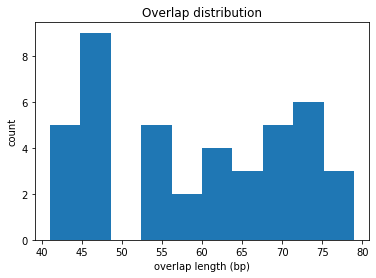

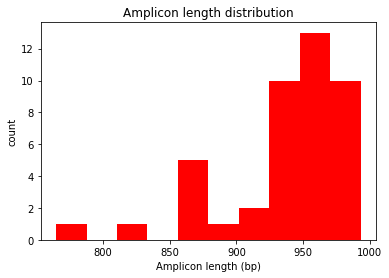

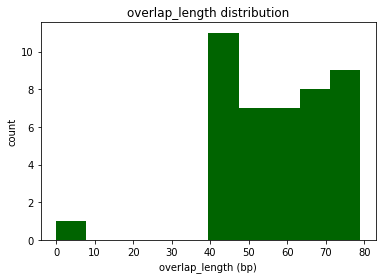

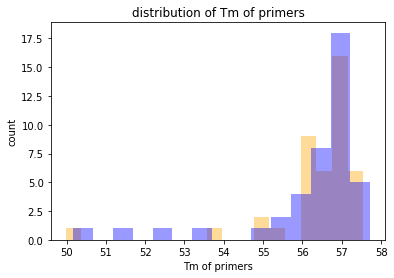

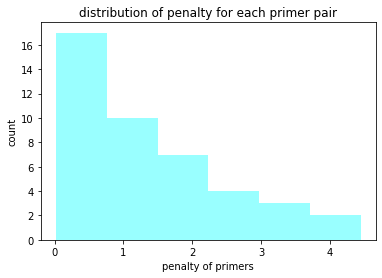

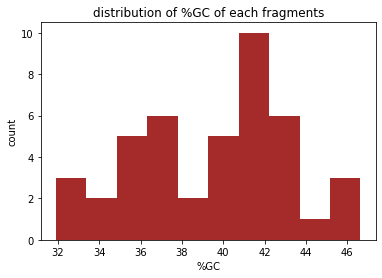

In [18]:
#Make a graph of the overlap distributions:
filename = "../meso/mfl_recoding/data/official_files/codex/first_tests/18.it0.wlen920minhomo_40maxhomo_80_CODEX.tsv"
primer_df =  pd.read_csv(filename, sep='\t')
plt.hist(primer_df['overlap_length'][primer_df['overlap_length'] > 0])
plt.title('Overlap distribution')
plt.xlabel('overlap length (bp)')
plt.ylabel('count')
plt.show()

#Make a graph of gblock_length:
plt.hist(primer_df['amplicon_len'], color = 'red')
plt.title('Amplicon length distribution')
plt.xlabel('Amplicon length (bp)')
plt.ylabel('count')
plt.show()

#Make a graph of overlap_len:
plt.hist(primer_df['overlap_length'], color = 'darkgreen')
plt.title('overlap_length distribution')
plt.xlabel('overlap_length (bp)')
plt.ylabel('count')
plt.show()

#Make a graph of the tm distribution: NOT A CUTE GRAPH ... AND NOT REALLY USEFULL TOO
right_array = [element for count,element in enumerate(primer_df['PRIMER_RIGHT_TM']) if count+1 != len(primer_df['PRIMER_RIGHT_TM'])]
left_array = [element for count,element in enumerate(primer_df['PRIMER_LEFT_TM']) if count+1 != len(primer_df['PRIMER_LEFT_TM'])]
sns.distplot(right_array, kde=False, color="orange", )
sns.distplot(left_array, kde=False, color="blue")
plt.title('distribution of Tm of primers')
plt.xlabel('Tm of primers')
plt.ylabel('count')
# plt.legend(loc='upper right')
plt.show()

#Make a graph of primer_penalty_distribution:
sns.distplot([penalty for penalty in primer_df['PRIMER_PENALTY']], kde=False, color="cyan")
plt.title('distribution of penalty for each primer pair')
plt.xlabel('penalty of primers')
plt.ylabel('count')
plt.show()

#Make a graph of %GC distribution of every fragments:
plt.hist(primer_df['perc_GC'], color = 'brown')
plt.title('distribution of %GC of each fragments')
plt.xlabel('%GC')
plt.ylabel('count')
plt.show()

In [10]:
with open("../ref_files_m13/m13_alt/alt_prom_v1_kan.fa") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        print(str(record.seq).upper())

AACGCTACTACTATTAGTAGAATTGATGCCACCTTTTCAGCTCGCGCCCCAAATGAAAATATAGCTAAACAGGTTATTGACCATTTGCGAAATGTATCTAATGGTCAAACTAAATCTACTCGTTCGCAGAATTGGGAATCAACTGTTACATGGAATGAAACTTCCAGACACCGTACTTTAGTTGCATATTTAAAACATGTTGAGCTACAGCACCAGATTCAGCAATTAAGCTCTAAGCCATCCGCAAAAATGACCTCTTATCAAAAGGAGCAATTAAAGGTACTCTCTAATCCTGACCTGTTGGAGTTTGCTTCCGGTCTGGTTCGCTTTGAAGCTCGAATTAAAACGCGATATTTGAAGTCTTTCGGGCTTCCTCTTAACCTCTTTGATGCTATCCGCTTTGCTTCTGACTACAACAGTCAGGGTAAAGACCTGATTTTTGATTTATGGTCATTCTCGTTTTCTGAACTGTTTAAAGCATTTGAGGGGGATTCAATGAATATTTATGACGATTCCGCAGTATTGGACGCTATCCAGTCTAAACATTTTACTATTACCCCCTCTGGCAAAACTTCTTTTGCAAAAGCCTCTCGCTATTTTGGTTTTTATCGTCGTCTGGTAAACGAGGGTTATGATAGTGTTGCTCTTACTATGCCTCGTAATTCCTTTTGGCGTTATGTATCTGCATTAGTTGAATGTGGTATTCCTAAATCTCAACTGATGAATCTTTCTACCTGTAATAATGTTGTTCCGTTAGTTCGTTTTATTAACGTAGATTTCAGCTCCCAACGTCCTGACTGGTACAATGAGCCCGTTCTTAAAATCGCATAAGGTAATTCACAATGATTAAAGTTGAAATTAAACCATCTCAAGCCCAATTTACTACTCGTTCTGGTGTTTCTCGTCAGGGCAAGCCTTATTCACTGAATGAGCAGCTTTGTTACGTTGATTTGGGTAATGAATATCCGGTTCTTGTCAAGATTACTCTTGATGAAGGTCA